In [ ]:
#pip install libpysal
#pip install geopandas
#pip install esda
#pip install splot
#pip install stargazer
#pip install mgwr

In [ ]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from pylab import rcParams
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 72

import seaborn as sns
sns.set_style("darkgrid")
sns.set_context(context="paper", font_scale=1.5, rc=None)
sns.set(font="serif")

import plotly.express as px
import plotly.graph_objects as go

import geopandas as gpd


import libpysal as ps
from libpysal  import weights
from libpysal.weights import Queen

import esda
from esda.moran import Moran, Moran_Local

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster, plot_local_autocorrelation
from splot.libpysal import plot_spatial_weights

from giddy.directional import Rose

import statsmodels.api as sm
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer, LineLocation

from spreg import OLS
from spreg import MoranRes
from spreg import ML_Lag
from spreg import ML_Error
from spreg import GM_Lag

from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import shift_colormap, truncate_colormap

import warnings
warnings.filterwarnings('ignore')
import time

import matplotlib.pyplot as plt
from shapely.geometry import Point



In [ ]:
# On charge nos données

df  = gpd.read_file('bayareatracts.shp')

In [ ]:
# Visualisation de nos données
df.head()

,GEOID,county,region,ltotp,lmedinc,pwhite,pblk,pasn,phisp,lmedhval,medage,medrooms,meddur,parks,edppl3,geometry
0,6.001400e+09,Alameda County,East Bay,8.003363,12.247181,0.692076,0.028084,0.161819,0.037780,13.914903,25.0,6.9,15.0,13.0,0.7911,"POLYGON ((-122.24692 37.88544, -122.24197 37.8..."
1,6.001400e+09,Alameda County,East Bay,7.599401,11.901583,0.713070,0.009014,0.098147,0.088633,13.859719,78.0,5.9,19.0,10.0,0.8244,"POLYGON ((-122.25742 37.84310, -122.25620 37.8..."
2,6.001400e+09,Alameda County,East Bay,8.541495,11.387056,0.669725,0.094085,0.097599,0.075151,13.757140,78.0,4.7,14.0,10.0,0.6044,"POLYGON ((-122.26416 37.84000, -122.26186 37.8..."
3,6.001400e+09,Alameda County,East Bay,8.291797,11.540745,0.657730,0.059634,0.121273,0.094463,13.679003,78.0,4.5,16.0,10.0,0.6844,"POLYGON ((-122.26180 37.84179, -122.26130 37.8..."
4,6.001400e+09,Alameda County,East Bay,8.279951,11.433612,0.533722,0.241126,0.055781,0.103195,13.489365,78.0,4.4,14.0,12.0,0.7133,"POLYGON ((-122.26941 37.84811, -122.26841 37.8..."


In [ ]:
# On établit notre matrice de pondération spatiale, on peut tester et visualiser pour différentes méthodes, différents k ...

W = weights.KNN.from_dataframe(df, k=8)
W.transform = 'r'
#maxMin = weights.min_threshold_dist_from_shapefile("bayareatracts.shp")
#W = weights.DistanceBand.from_dataframe(df, threshold = maxMin, binary=False, alpha=-2)
#W.transform = 'r'

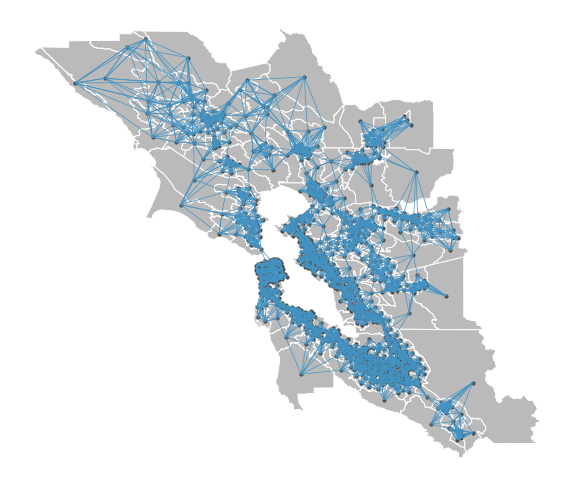

In [ ]:
plot_spatial_weights(W, df);

On a besoin d'une matrice de pondération spatiale afin que nos modèles de régression spatiale prennent en compte les relations spatiales entre nos observations.

In [ ]:
# Paramètres pour nos régressions


X = np.array(df[["ltotp", "lmedinc", "medage","medrooms","meddur","parks","edppl3"]])
Y = df["lmedhval"].values
x_name = ["ltotp", "lmedinc", "medage","medrooms","meddur","parks","edppl3"]

# Estimation par les MCO

In [ ]:
model_MCO = OLS(y = Y, x = X, w = W, name_x = x_name, name_w = 'W', name_ds = 'df',white_test=True, spat_diag=True, moran=True)
print(model_MCO.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :          df
Weights matrix      :           W
Dependent Variable  :     dep_var                Number of Observations:        1576
Mean dependent var  :     13.4019                Number of Variables   :           8
S.D. dependent var  :      0.5219                Degrees of Freedom    :        1568
R-squared           :      0.6422
Adjusted R-squared  :      0.6406
Sum squared residual:     153.523                F-statistic           :    401.9728
Sigma-square        :       0.098                Prob(F-statistic)     :           0
S.E. of regression  :       0.313                Log likelihood        :    -401.155
Sigma-square ML     :       0.097                Akaike info criterion :     818.310
S.E of regression ML:      0.3121                Schwarz criterion     :     861.211

-----------------------------------------------------------------------------

On observe que parmi nos variables explicatives,eddp13 et lmedinc sont les variables les plus influentes sur notre variable cible lmedhval, pour une unité d'augmentation de lmedhval, lmedinc et eddp13 augmentent de 0.76 et 0.90 respectivement.

Et les résultats sont assez logique, il semble en effet évident qu'une variable représentant la valeur médianne des maisons du voisinage soit très influente sur la valeur de notre foyer, ainsi que la présence ou nom d'enfant ayant une bonne éducation souvent révélateur d'un environnement aisé ou non.

Nos résultats des tests nous indique:

Le test de Moran's I qui évalue la corrélation spatiale globale de nos données à une valeur de 0.4078, on a donc la présence d'une corrélation corrélation spatiale globale dans nos données.

Les tests de Lagrange Multiplier (lag), Robust LM (lag), Lagrange Multiplier (error), et Robust LM (error) ont tous donné des résultats significatifs avec une valeur p de 0, donc on peut suggérer une forte présence de dépendance spatiale locale.

Le test de Lagrange Multiplier (SARMA) évalue la présence de dépendance spatiale autorégressive. Dans notre cas, le test a donné un résultat significatif avec une valeur p de 0, ce qui suggère une forte présence de dépendance spatiale autorégressive.

# Modèle de régression aspatial avec des indicatrices

On va créer des indicatrices correspondant à chaque région, par exemple: si est situé à East Bay : alors 1 sinon 0 etc, pour notre modèle

In [ ]:
df['region']

0        East Bay
1        East Bay
2        East Bay
3        East Bay
4        East Bay
          ...    
1571    North Bay
1572    North Bay
1573    North Bay
1574    North Bay
1575    North Bay
Name: region, Length: 1576, dtype: object

In [ ]:
indicatrices_regions = pd.get_dummies(df['region'])
print(indicatrices_regions)

      East Bay  North Bay  Peninsula  San Francisco  South Bay
0            1          0          0              0          0
1            1          0          0              0          0
2            1          0          0              0          0
3            1          0          0              0          0
4            1          0          0              0          0
...        ...        ...        ...            ...        ...
1571         0          1          0              0          0
1572         0          1          0              0          0
1573         0          1          0              0          0
1574         0          1          0              0          0
1575         0          1          0              0          0

[1576 rows x 5 columns]


In [ ]:
X = pd.concat([df[['ltotp', 'lmedinc', 'medage', 'medrooms', 'meddur', 'parks', 'edppl3']], indicatrices_regions], axis=1)
Y = df["lmedhval"]

In [ ]:
model = sm.OLS(Y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               lmedhval   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.689
Method:                 Least Squares   F-statistic:                     318.4
Date:                Fri, 03 Mar 2023   Prob (F-statistic):               0.00
Time:                        10:19:57   Log-Likelihood:                -284.72
No. Observations:                1576   AIC:                             593.4
Df Residuals:                    1564   BIC:                             657.8
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
ltotp            -0.0632      0.017     -3.818

Les différentes sorties des coefficients nous montre que si notre maison est situé à San Francisco ou Peninsula, elle est plus à même d'avoir un prix médian plus élevé que si notre maison est situé sur East Bay ou North Bay, l'ajout des indicatrices nous a aussi permis de rendre le modèle un peu plus précis en augmentant notre R2 à 0.691

# Modèle de régression avec des interactions

On se propose d'ajouter une variable contrôlant l'effet de l'interaction entre l'âge médian et le nombre de chambres sur notre prix médian des logements.

On ajoute aussi une variable contrôlant l'effet de l'interaction entre la densité de population et le revenu médian sur la valeur médiane de l'habitation.


In [ ]:
df['medage_medrooms'] = df['medage'] * df['medrooms']
df['ltotp_lmedinc'] = df['ltotp'] * df['lmedinc']


X = np.array(df[["ltotp", "lmedinc", "medage","medrooms","meddur","parks","edppl3","medage_medrooms","ltotp_lmedinc"]])
Y = df["lmedhval"].values
x_name = ["ltotp", "lmedinc", "medage","medrooms","meddur","parks","edppl3","medage_medrooms","ltotp_lmedinc"]

W = weights.KNN.from_dataframe(df, k=8)
W.transform = 'r'

model_MCO_Interaction = OLS(y = Y, x = X, w = W, name_x = x_name, name_w = 'W', name_ds = 'df',white_test=True, spat_diag=True, moran=True)
print(model_MCO_Interaction.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :          df
Weights matrix      :           W
Dependent Variable  :     dep_var                Number of Observations:        1576
Mean dependent var  :     13.4019                Number of Variables   :          10
S.D. dependent var  :      0.5219                Degrees of Freedom    :        1566
R-squared           :      0.6455
Adjusted R-squared  :      0.6435
Sum squared residual:     152.083                F-statistic           :    316.8498
Sigma-square        :       0.097                Prob(F-statistic)     :           0
S.E. of regression  :       0.312                Log likelihood        :    -393.730
Sigma-square ML     :       0.096                Akaike info criterion :     807.461
S.E of regression ML:      0.3106                Schwarz criterion     :     861.087

-----------------------------------------------------------------------------

Notre coefficient pour notre variable d'interaction medage_medrooms est de  -0.0001924, ce qui signifie qu'une augmentation de 1 unité de l'interaction entre l'âge médian et le nombre de chambres est associée à une diminution de 0.0001924 unité de la valeur médiane des logements, il faut cependant nuancé cette observation car la p_value associé est non significative, on peut donc suggérer que l'interaction n'a pas d'effet significatif sur le prix médian des logements.

Notre coefficient pour notre variable d'interaction ltotp_lmedinc est de 0.1339222, ce qui signifie qu'une augmentation de 1 unité de l'interaction entre la densité de population et le revenu médian est associée à une augmentation de 0.1339222 unité de la valeur médiane des logements, on peut noter une p_value significative car < 0.05, donc on peut suggérer que l'interaction ltotp_lmedinc a un effet significatif sur le prix médian des logements.

On peut noter aussi que en comparant avec notre modèle MCO, on a une légère amélioration en précision en passant d'un R2 de 0.6422 à 0.6455

# Modèle stratifié et régression sur chaque strate

On va stratifier notre variable lmedinc car comme le montre les modèles précédents, elle est la variable avec la plus grande influence sur les valeurs de lmedhval (le prix médian des maisons dans chaque quartier).

Il peut être intéressant de regarder notre variable lmedinc car il semble assez évident que les quartiers avec un revenu médian plus élevé sont plus à même à d'acquérir des maisons plus chères, tandis que les quartiers avec un revenu médian plus faible ont tendance à avoir des maisons moins chères.

Nos modèles précédents ont suggéré une forte dépendance spatiale dans nos données. Pour notre modèle stratifié, on utilisera le modèle GM-LAG qui est efficace dans le cas de modélisation de relations spatiales dans les données.

In [ ]:
df['strates'] = pd.qcut(df["lmedinc"], q=3)

# On crée une liste vide pour stocker nos résultats futurs
results = []

# On itère pour chacune des strates de lmedinc et on applique notre modèle de régression pour chacune des strates
for s in df['strates'].unique():

    # On définit nos variables explicatives, cibles pour chacune des strates, ainsi que notre matrice de pondération spatiale
    df_strat = df[df['strates'] == s]
    y = df_strat['lmedhval'].values
    X = df_strat[['ltotp', 'medage', 'medrooms', 'meddur', 'parks', 'edppl3']].values
    W = weights.KNN.from_dataframe(df_strat, k=8)
    W.transform = 'r'
    # Modèle
    model = GM_Lag(y, X, w =W, name_y='lmedhval', name_x=['ltotp', 'medage', 'medrooms', 'meddur', 'parks', 'edppl3'],
                         name_w='W', name_ds='df_strat')

    results.append(model)

# Affichage des résultats
for i, result in enumerate(results):
    print(f"Strates {i+1}:")
    print(result.summary)

Strates 1:
REGRESSION
----------
SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :    df_strat
Weights matrix      :           W
Dependent Variable  :    lmedhval                Number of Observations:         525
Mean dependent var  :     13.8342                Number of Variables   :           8
S.D. dependent var  :      0.3627                Degrees of Freedom    :         517
Pseudo R-squared    :      0.7450
Spatial Pseudo R-squared:  0.0203

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT       0.7726198       0.9549491       0.8090691       0.4184754
               ltotp       0.0215326       0.0179751       1.1979144       0.2309504
              medage       0.0035255       0.000

On peut constater que pour différentes strates de notre variable lmedinc, nous n'obtenons pas les mêmes résultats.

Si on compare, on peut voir que notre première strate obtient un très bon R2 ainsi que des coefficients significatifs par rapport à notre variable lmedhval.

Cela nous suggère que peut cette strate contient des caractéristiques uniques qui influencent lmehdval de manière plus significative que les autres strates.

On peut supposer que notre première strate présente une plus grande homogénéité des caractéristiques de nos données, d'où un R2 plus précis.

# Régimes spatiaux

On se propose d'utiliser les modèles SAR ET SEM

In [ ]:
# Paramètres pour nos régressions


X = np.array(df[["ltotp", "lmedinc", "medage","medrooms","meddur","parks","edppl3"]])
Y = df["lmedhval"].values
x_name = ["ltotp", "lmedinc", "medage","medrooms","meddur","parks","edppl3"]
W = weights.KNN.from_dataframe(df, k=8)
W.transform = 'r'

model_SEM = ML_Error(y = Y, x = X, w = W, name_x = x_name, name_w = 'W', name_ds = 'df')
print(model_SEM.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL ERROR (METHOD = FULL)
-------------------------------------------------------------------
Data set            :          df
Weights matrix      :           W
Dependent Variable  :     dep_var                Number of Observations:        1576
Mean dependent var  :     13.4019                Number of Variables   :           8
S.D. dependent var  :      0.5219                Degrees of Freedom    :        1568
Pseudo R-squared    :      0.4978
Sigma-square ML     :       0.049                Log likelihood        :      39.100
S.E of regression   :       0.222                Akaike info criterion :     -62.199
                                                 Schwarz criterion     :     -19.298

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------------------------------------

In [ ]:
# Paramètres pour nos régressions


X = np.array(df[["ltotp", "lmedinc", "medage","medrooms","meddur","parks","edppl3"]])
Y = df["lmedhval"].values
x_name = ["ltotp", "lmedinc", "medage","medrooms","meddur","parks","edppl3"]
W = weights.KNN.from_dataframe(df, k=8)
W.transform = 'r'

model_SAR = ML_Lag(y = Y, x = X, w = W, name_x = x_name, name_w = 'W', name_ds = 'df')
print(model_SAR.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :          df
Weights matrix      :           W
Dependent Variable  :     dep_var                Number of Observations:        1576
Mean dependent var  :     13.4019                Number of Variables   :           9
S.D. dependent var  :      0.5219                Degrees of Freedom    :        1567
Pseudo R-squared    :      0.8021
Spatial Pseudo R-squared:  0.6605
Sigma-square ML     :       0.054                Log likelihood        :      17.251
S.E of regression   :       0.232                Akaike info criterion :     -16.502
                                                 Schwarz criterion     :      31.761

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------

Les modèles SAR et SEM nous sortent des résultats différents. Cela est normal car SAR utilise un terme de lag spatial, qui est non présent dans le modèle SEM.

On observe de meilleurs résultats pour le modèle SAR avec un R2 de 0.8021 contre 0.4978 pour le modèle SEM, on peut suggérer que le modèle SAR est plus approprié pour nos données car il explique une plus grande proportion de la variance de lmedhval.

# Régression géographiquement pondérée

On utilise le modèle GWR

In [ ]:
# Créer une nouvelle colonne "coords" qui contient nos coordonnées de chaque observation en se basant sur notre colonne geometry
df['coords'] = df['geometry'].apply(lambda x: Point(x.centroid.x, x.centroid.y))

# On crée nos deux nouvelles colonnes pour pouvoir par la suite choisir la meilleur largeur de bande pour pouvoir faire notre régression géographiquement pondéré
df['X'] = df['coords'].apply(lambda x: x.x)
df['Y'] = df['coords'].apply(lambda x: x.y)

In [ ]:
# Choix optimal de la largeur de bande pour GWR

X = df[["ltotp", "lmedinc", "medage","medrooms","meddur","parks","edppl3"]].values
Y = df["lmedhval"].values.reshape((-1,1))

u = df['X']
v = df['Y']
coords = list(zip(u,v))
gwr_selector = Sel_BW(coords, Y, X)
gwr_bw = gwr_selector.search()

print('GWR bandwidth =', gwr_bw)

GWR bandwidth = 76.0


In [ ]:
# Modèle de régression géographiquement pondérée
gwr_results = GWR(coords, Y, X, gwr_bw).fit()
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                1576
Number of covariates:                                                     8

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            153.523
Log-likelihood:                                                    -401.155
AIC:                                                                818.310
AICc:                                                               820.425
BIC:                                                             -11391.105
R2:                                                                   0.642
Adj. R2:                                                              0.641

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

Dans la sortie globale de la régression, on peut voir que notre modèle a un R2 ajusté de 0,641, ainsi qu'un AICc de 820,425, ce qui indique une bonne adéquation du modèle aux données.

Comme on pouvait s'y attendre, les résultats de notre régression géographiquement pondérée est très différent de notre sortie globale de la régression, en effet, on a calculé les coefficients de chaque variable en utilisant des poids différents basés sur leur proximité géographique avec d'autres observations.

Les sorties du modèle GWR nous montre une forte amélioration du R2 ajusté de 0.87, on peut donc conclure que la prise en compte de la variation spatiale a fortement amélioré la précision de notre modèle. Les coefficients de nos variables ont aussi fluctués, on peut donc suggérer que selon l'emplacement géographique, les relations entre nos variables n'ont pas les mêmes valeurs.

# Représentations graphiques

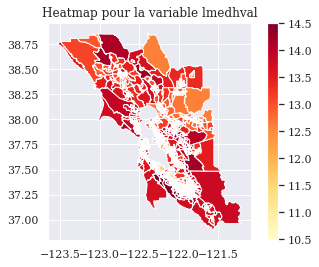

In [ ]:
# On représente une heatmap de la variable lmedhval, à savoir, visualiser la distribution de la variable lmedhval dans la région de la baie de San Francisco

df.plot(column='lmedhval', cmap='YlOrRd', legend=True)
plt.title("Heatmap pour la variable lmedhval")
plt.show()

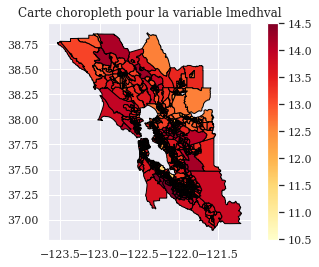

In [ ]:
# On colorie chaque zone géographique selon sa valeur de lmedhval
df.plot(column='lmedhval', cmap='YlOrRd', legend=True, edgecolor='black')
plt.title("Carte choropleth pour la variable lmedhval")
plt.show()

<AxesSubplot:>

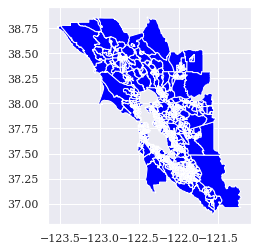

In [ ]:
df.plot(color='blue')

<AxesSubplot:>

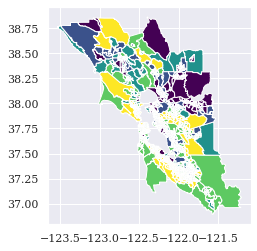

In [ ]:
df.plot(column='lmedhval', scheme='QUANTILES')

<AxesSubplot:>

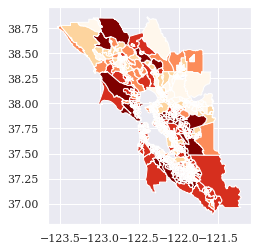

In [ ]:
df.plot(column='lmedhval', scheme='QUANTILES', k=5, cmap='OrRd')

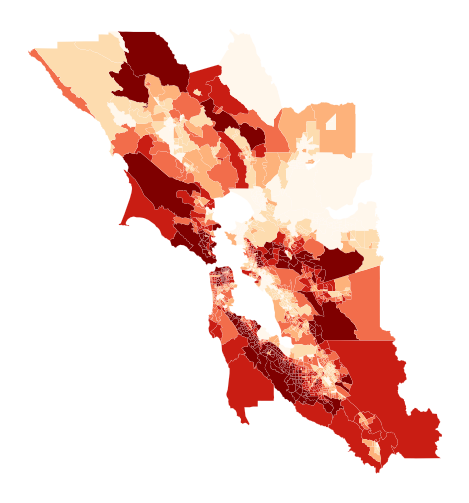

In [ ]:
f, ax = plt.subplots(1, figsize=(9, 9))
df.plot(column='lmedhval', scheme='QUANTILES', \
        k=6, cmap='OrRd', linewidth=0.1, ax=ax, \
        edgecolor='white')
ax.set_axis_off()
plt.show()

On remarque sur tous les graphes que le centre et la baie en elle même est beaucoup plus foncé donc beuacoup plus cher que la partie extérieure, loin de la mer.